# 3. Deeper dive into model architectures and practical aspacts in training

Now that we have a good understanding how the keras API works we'll mainly work on two things:

1. Building more complex architectures.
    - What happens if not all inputs are numerical?
    - How can we use inputs of more than one data type?
    - What are Embedding layers and how can they help us?
2. Practical aspects regarding model training.
    - What is the history callback and how can we use it?
    - How can we visualize how our model is doing during training?
3. Bonus practical aspects:  
    - What is model calibration and how can we visualize it?
    - How can we perform hyperparameter tuning?

In [1]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

2023-04-11 23:28:22.438471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 23:28:22.575606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 23:28:22.575622: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-11 23:28:23.282894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataset

To better demonstrate the topics that we want to discuss, we'll use a different dataset than the toy example we've seen up till now. The dataset is called *airlines_delay* and can be found in [Kaggle](https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay). This dataset consists of 7 features (4 numerical, 3 string) and the goal of this dataset is to predict if a flight will be delayed (essentially a binary classification task).

In [2]:
data = pd.read_csv('../data/airlines_delay.csv')
data

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1


The thing that is going to give us the most trouble is the 3 categorical variables it has, `Airline`, `AirportFrom` and `AirportTo`.

In [3]:
print(data['Airline'].value_counts(), '\n')
print(data['AirportFrom'].value_counts(), '\n')
print(data['AirportTo'].value_counts())

WN    94097
DL    60940
OO    50254
AA    45656
MQ    36604
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: Airline, dtype: int64 

ATL    34449
ORD    24822
DFW    22153
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64 

ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64


## Part 1: Deeper dive into model architectures

### Attempt 1: Ignore categorical features

For our first attempt we'll completely ignore these categorical features and only deal with the numerical features.

In [4]:
X = data.drop(columns=['Airline', 'AirportFrom', 'AirportTo', 'Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
inp = tf.keras.layers.Input((4,))
hid1 = tf.keras.layers.Dense(300, activation='relu')(inp)
hid2 = tf.keras.layers.Dense(100, activation='relu')(hid1)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid2)

model = tf.keras.models.Model(inp, out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                     'Precision',  # for some reason 
                                                                     'Recall',     # these are 
                                                                     'AUC'])       # case sensitive

model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10


2023-04-11 23:28:25.192118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-11 23:28:25.192144: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-11 23:28:25.192190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvidia/version does not exist
2023-04-11 23:28:25.192480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2950/2950 [==============================] - 8s 3ms/step - loss: 2.3445 - accuracy: 0.5180 - precision: 0.4589 - recall: 0.4567 - auc: 0.5164 - val_loss: 0.7498 - val_accuracy: 0.5649 - val_precision: 0.5222 - val_recall: 0.2688 - val_auc: 0.5617
Epoch 2/10
2950/2950 [==============================] - 7s 2ms/step - loss: 0.9715 - accuracy: 0.5311 - precision: 0.4717 - recall: 0.4376 - auc: 0.5283 - val_loss: 0.9063 - val_accuracy: 0.5585 - val_precision: 0.5753 - val_recall: 0.0315 - val_auc: 0.5613
Epoch 3/10
2950/2950 [==============================] - 7s 2ms/step - loss: 0.8336 - accuracy: 0.5406 - precision: 0.4824 - recall: 0.4261 - auc: 0.5390 - val_loss: 0.6839 - val_accuracy: 0.5503 - val_precision: 0.4913 - val_recall: 0.2880 - val_auc: 0.5606
Epoch 4/10
2950/2950 [==============================] - 7s 2ms/step - loss: 0.7400 - accuracy: 0.5509 - precision: 0.4951 - recall: 0.4070 - auc: 0.5499 - val_loss: 0.6779 - val_accuracy: 0.5709 - val_precision: 0.5729 - val_recall: 0.14

In [6]:
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']

results = model.evaluate(X_test, y_test)

for name, value in zip(metrics, results):
    print(f'{name:<10}: {value:.2f}')

5057/5057 [==============================] - 6s 1ms/step - loss: 0.6736 - accuracy: 0.5705 - precision: 0.5528 - recall: 0.1854 - auc: 0.6025
Loss      : 0.67
Accuracy  : 0.57
Precision : 0.55
Recall    : 0.19
AUC       : 0.60


Arguably we're not great really great results in this setup. We could try to tune the architecture or other hyperparams like the learning rate more, but I don't think this would lead to a significant boost in performance. A much more promissing direction would be to try to incorporate the other features to the model.

### Attempt 2: Embed categorical features

We want to utilize the remaining features of the model, however these are in a form not understandable by our network, i.e. **categorical**. The most common way to deal with this issue is to **represent each catebory by a fixed length vector**. These vectors are called **embeddings** and are **fully trainable**. But how does this work?

Before we begin, we need to define a **vocabulary size** (let's call this $V$) and an **embedding dim** (let's say this is $D$. The second is simply the size of each embedding (i.e. how many dims will the vector that represents each category have). The first shows how many categories will get their own, dedicated embedding. In features that don't have too many unique values, this is set to be the same as the cardinality of the feature (i.e. every unique value gets its own dedicated embedding). If the feature has too many unique values, only the $V$ most frequent categories will get their own embedding. The remaining will usually all be represented by a single embedding that we call OOV (i.e. out-of-vocabulary). Keras calls these two properites `input_dim` and `output_dim` respectively.

Internally, a lookup table of dimensions $V \times D$ is created, where each row refers to a category. All of these parameters are trainable! When the network sees a specific input, it looks up the $D$-dimensional embedding of that input and feeds it to the next layer. 

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/embedding.png)

In keras this is implemented through the [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer. The embedding layer doesn't work by default on string inputs, though. They first need to be encoded as integers. For this purpose we will use the [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layer.

How can we use embeddings in our case, though?

There are a few things to notice in our case:
- We have very small vocabulary sizes. This means that we can have dedicated embeddings for the whole vocabulary$^1$
- The two airport features have the same exact vocabulary, so we will use a single embedding table for both of these.
- We have both numerical and categorical features we wan't to use. This means that we'll need to embed the categories (each feature separately) and then concatenate the embeddings with the numeric features. Let's say we use an embedding size of $3$ for the airline and $5$ for each of the airport features. The concatenated vector that will be fed to the dense layers will have $17$ dims: $3$ (Airline) $+5$ (AirportFrom) $+5$ (AirportTo) $+4$ (numeric) $=17$.

$^1$ *Note: this isn't a good practive, as some categories that don't have many samples will not get many updates for their embeddings, leaving them undertrained. Because this requires tuning, though, we won't play with OOV embeddings at all.*

In [7]:
# Input for the 4 numeric features of the dataset
numeric_inp = tf.keras.layers.Input((4,))  # shape --> (batch, 4)

# Make separate inputs for the 3 categorical features
airline_inp = tf.keras.layers.Input((1,), dtype=tf.string)
airport_from_inp = tf.keras.layers.Input((1,), dtype=tf.string)
airport_to_inp = tf.keras.layers.Input((1,), dtype=tf.string)

# Create lookup tables mapping the strings to integers
airline_look = tf.keras.layers.StringLookup(vocabulary=data['Airline'].unique())
airport_look = tf.keras.layers.StringLookup(vocabulary=data['AirportTo'].unique())

# Encode the 3 categorical features using the lookup tables
airline_encoded = airline_look(airline_inp)
airport_from_encoded = airport_look(airport_from_inp)
airport_to_encoded = airport_look(airport_to_inp)

# Create embedding tables for each of the 3 categorical features
airline_emb = tf.keras.layers.Embedding(input_dim=len(data['Airline'].unique())+1,  
                                        output_dim=3)  # the +1 is for the OOV embedding
airport_emb = tf.keras.layers.Embedding(input_dim=len(data['AirportTo'].unique())+1,
                                        output_dim=5)

# Add the embeddings as layers after their respective inputs
airline_vec = airline_emb(airline_encoded)            # shape --> (batch, 1, 3)
airport_from_vec = airport_emb(airport_from_encoded)  # shape --> (batch, 1, 5)
airport_to_vec = airport_emb(airport_to_encoded)      # shape --> (batch, 1, 5)

# Flatten the embeddings, so that they can be concatenated with the numeric features
airline_vec = tf.keras.layers.Flatten()(airline_vec)            # shape --> (batch, 3)
airport_from_vec = tf.keras.layers.Flatten()(airport_from_vec)  # shape --> (batch, 5)
airport_to_vec = tf.keras.layers.Flatten()(airport_to_vec)      # shape --> (batch, 5)

# Concatenate the embeddings together with the numeric inputs
concat = tf.keras.layers.Concatenate()([numeric_inp, airline_vec, airport_from_vec,
                                        airport_to_vec])  # shape --> (batch, 17)

# Add dense layers 
hid1 = tf.keras.layers.Dense(300, activation='relu')(concat)
hid2 = tf.keras.layers.Dense(100, activation='relu')(hid1)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid2)

# Define model. We need to define all the inputs we used.
# We'll do this as a dict to be more safe when passing the values during training
model = tf.keras.models.Model(inputs={'numeric': numeric_inp,
                                      'airline': airline_inp,
                                      'airport_from': airport_from_inp,
                                      'airport_to': airport_to_inp},
                              outputs=out)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision',
                                                                     'Recall', 'AUC'])

A sketch of our model's architecture can be seen below.

![Embedding model architecture](https://github.com/djib2011/tensorflow-training/blob/main/figures/airline_embeddings_architecture.png?raw=true)

Let's prepare the dataset in the form that our model expects it.

In [8]:
X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


def convert_to_dict(df):
    return {'numeric': df.drop(columns=['Airline', 'AirportFrom', 'AirportTo']).astype(float).values,
            'airline': df['Airline'],
            'airport_from': df['AirportFrom'],
            'airport_to': df['AirportTo']}


X_train = convert_to_dict(X_train)
X_test = convert_to_dict(X_test)

Train and evaluate our model.

In [9]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
2950/2950 [==============================] - 28s 9ms/step - loss: 2.1763 - accuracy: 0.5621 - precision: 0.5084 - recall: 0.5056 - auc: 0.5602 - val_loss: 0.6649 - val_accuracy: 0.6234 - val_precision: 0.5869 - val_recall: 0.5225 - val_auc: 0.6586
Epoch 2/10
2950/2950 [==============================] - 26s 9ms/step - loss: 0.8667 - accuracy: 0.5956 - precision: 0.5490 - recall: 0.5163 - auc: 0.6086 - val_loss: 0.6492 - val_accuracy: 0.6220 - val_precision: 0.5686 - val_recall: 0.6285 - val_auc: 0.6770
Epoch 3/10
2950/2950 [==============================] - 26s 9ms/step - loss: 0.7173 - accuracy: 0.6145 - precision: 0.5748 - recall: 0.5165 - auc: 0.6377 - val_loss: 0.6402 - val_accuracy: 0.6371 - val_precision: 0.6514 - val_recall: 0.3991 - val_auc: 0.6771
Epoch 4/10
2950/2950 [==============================] - 25s 9ms/step - loss: 0.6646 - accuracy: 0.6252 - precision: 0.5928 - recall: 0.5061 - auc: 0.6559 - val_loss: 0.6288 - val_accuracy: 0.6452 - val_precision: 0.6534 - v

In [10]:
results = model.evaluate(X_test, y_test)

for name, value in zip(metrics, results):
    print(f'{name:<10}: {value:.2f}')

5057/5057 [==============================] - 15s 3ms/step - loss: 0.6265 - accuracy: 0.6466 - precision: 0.6262 - recall: 0.5133 - auc: 0.6939
Loss      : 0.63
Accuracy  : 0.65
Precision : 0.63
Recall    : 0.51
AUC       : 0.69


By adding these categorical features we managed to improve the model's performance bit. By tuning parameters such as the embedding dim and the vocabulary size, we might get an even better performance out of our embeddings.

## Part 1: Practical aspects regarding model training

### History callback

You might have noticed in the previous training that I assigned the output of `model.fit()` to a variable called `hist`. This is called the [History callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History). This stores all information relevant to the model's training (i.e. the stuff that is printed on screen). This callback gives us access to this information, which we can use for analysis, visualizations, etc.

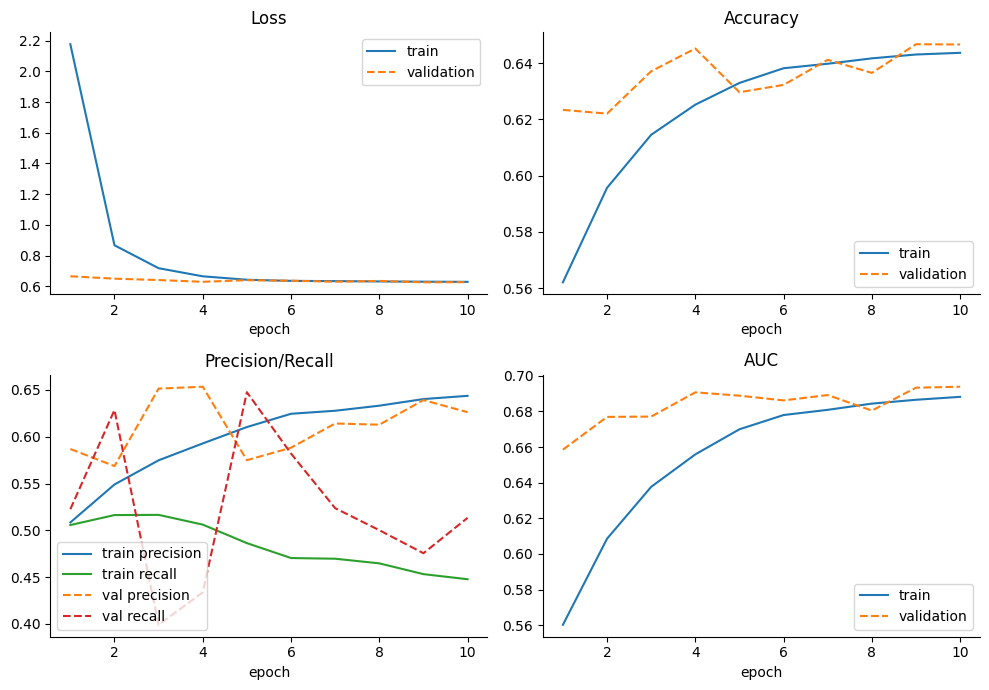

In [11]:
######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(10, 7))

def common_mod_axes(ax):
    ax.set_xlabel('epoch')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax = plt.subplot(221)
ax.plot(range(1, 11), hist.history['loss'], label='train')
ax.plot(range(1, 11), hist.history['val_loss'], ls='--', label='validation')
ax.set_title('Loss')
common_mod_axes(ax)

ax = plt.subplot(222)
ax.plot(range(1, 11), hist.history['accuracy'], label='train')
ax.plot(range(1, 11), hist.history['val_accuracy'], ls='--', label='validation')
ax.set_title('Accuracy')
common_mod_axes(ax)

ax = plt.subplot(223)
ax.plot(range(1, 11), hist.history['precision'], color='C0', label='train precision')
ax.plot(range(1, 11), hist.history['recall'], color='C2', label='train recall')
ax.plot(range(1, 11), hist.history['val_precision'], color='C1', ls='--', label='val precision')
ax.plot(range(1, 11), hist.history['val_recall'], color='C3', ls='--', label='val recall')
ax.set_title('Precision/Recall')
common_mod_axes(ax)

ax = plt.subplot(224)
ax.plot(range(1, 11), hist.history['auc'], label='train')
ax.plot(range(1, 11), hist.history['val_auc'], ls='--', label='validation')
ax.set_title('AUC')
common_mod_axes(ax)

plt.tight_layout()

The history callback provides an interesting look into how the model's performance improved through training. There are several situations where it would be very useful if we could have access to this information **during training**, e.g. we are running a long experiment and see if we want to end it prematurely. 

### TensorBoard

TensorBoard is a UI through which we can visualize metrics, histograms, the model's graph (in terms of pure ops), interact with embedding projections, profile our models and more. It is an external service to TensorFlow that can either be run standalone or through the notebook. 

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Let's continue the model's training for a few more epochs, but this time add the tensorboard callback. This doesn't affect the model's training, it just logs some stuff.

In [13]:
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test),
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs')])

Epoch 1/5
2950/2950 [==============================] - 27s 9ms/step - loss: 0.6281 - accuracy: 0.6442 - precision: 0.6430 - recall: 0.4523 - auc: 0.6890 - val_loss: 0.6301 - val_accuracy: 0.6418 - val_precision: 0.6035 - val_recall: 0.5719 - val_auc: 0.6930
Epoch 2/5
2950/2950 [==============================] - 26s 9ms/step - loss: 0.6275 - accuracy: 0.6446 - precision: 0.6446 - recall: 0.4503 - auc: 0.6900 - val_loss: 0.6267 - val_accuracy: 0.6448 - val_precision: 0.6233 - val_recall: 0.5125 - val_auc: 0.6923
Epoch 3/5
2950/2950 [==============================] - 27s 9ms/step - loss: 0.6271 - accuracy: 0.6452 - precision: 0.6458 - recall: 0.4506 - auc: 0.6901 - val_loss: 0.6327 - val_accuracy: 0.6401 - val_precision: 0.5946 - val_recall: 0.6041 - val_auc: 0.6945
Epoch 4/5
2950/2950 [==============================] - 26s 9ms/step - loss: 0.6267 - accuracy: 0.6449 - precision: 0.6446 - recall: 0.4517 - auc: 0.6907 - val_loss: 0.6248 - val_accuracy: 0.6463 - val_precision: 0.6409 - val_r

The callback has created a coupe of log files (one for train and one for validation) under `logs/`.

In [14]:
!ls logs/*

logs/train:
events.out.tfevents.1681245261.home.20765.0.v2

logs/validation:
events.out.tfevents.1681245283.home.20765.1.v2


These can be inspected through TensorBoard. We'll use the tensorboard magic command to load the UI in the notebook.

In [23]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 21356), started 0:02:20 ago. (Use '!kill 21356' to kill it.)

TensorBoard can also be launched independently from the notebook (which is aguably more useful) using the following command in any terminal:

```
tensorboard --logdir logs
```

Where `logs` is the path to your log directory. TensorBoard will launch its server (by default in `localhost:6006`) and will load all valid log files under the log dir. You can access the UI using any browser (usually it opens on its own).

A deep dive into TensorBoard's various functionalities can be found [here](https://neptune.ai/blog/tensorboard-tutorial).


## Part 3: Misc practical tips

### Plotting a model's calibration curve

Model calibration is a more advanced topic that we won't get into. In short, in models that output probabilities, a useful property we would like our model to have is: if it outputs a probability of $p$ for an outcome, we want this outcome to actually have a $p$ chance of occurring. E.g. if our model forecasts weather, out of all the times you said there was a $40%$ chance of rain, how often did rain actually occur? (If you're interested in a deeper dive in model calibration you can read [this blog](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)). 

What might interest us is plotting the model's calibration curve to see if it's predictions are calibrated or not. This can be done easily as follows.

5057/5057 [==============================] - 15s 3ms/step


Text(0.5, 1.0, 'Calibration curve')

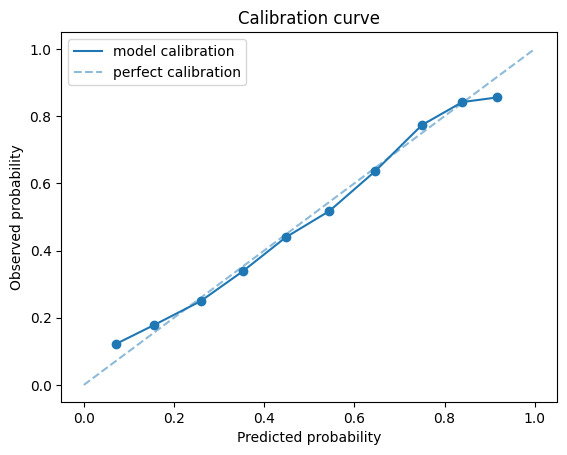

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, model.predict(X_test), n_bins=10)

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.plot(prob_pred, prob_true, label='model calibration')
plt.plot([0, 1], [0, 1], color='C0', ls='--', alpha=0.5, label='perfect calibration')
plt.scatter(prob_pred, prob_true, c='C0')


plt.legend()

plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')

plt.title('Calibration curve')

### Visualizing embeddings in TensorBoard

Interesting insights and potential debuggging can be achieved by visualizing the embeddings to see the associations they have learned. This means that we will export the weights of an embedding table (remember these were essentially vectors describing each unique value of a certain feature), use a dimensionality reduction technique (e.g. PCA, t-SNE) to project these vectors to 3d and visualize them through TensorBoard. 

This can be done as follows.

In [17]:
from tensorboard.plugins import projector

Get the weights of the embedding table we want and export them as a TF checkpoint

In [18]:
weights = tf.Variable(model.layers[6].get_weights()[0])  # Airport embedding table
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save('logs/airlines/embedding.ckpt')

'logs/airlines/embedding.ckpt-1'

Write the metadata. We need because the embedding table works on integer inputs (we used a `StringLookup` to map the cateories to integers). With this the projector will assign the actual category names to the points.

In [19]:
with open('logs/airlines/metadata.tsv', 'w') as f:
    for airport in model.layers[4].get_vocabulary():
        f.write(f'{airport}\n')

Configure the projector.

In [20]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings('logs/airlines', config)

Lauch tensorboard again. You might need to kill the old TensorBoard process for this to work. Also sometimes you will need to refresh TensorBoard for the projector to appear (just run the cell below two times).

In [22]:
%tensorboard --logdir logs/airlines --port 6007

Reusing TensorBoard on port 6007 (pid 21469), started 0:01:48 ago. (Use '!kill 21469' to kill it.)

### Extra resources

- Hyperparameter tuning via a TensorBoard [plugin](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams).
- Profiling in TensorBoard: 
[[1]](https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras), 
[[2]](https://www.tensorflow.org/guide/profiler), 
[[3]](https://www.tensorflow.org/guide/gpu_performance_analysis). 